## Temperature forecasting for different cities in the world

## Introduction
For this project you are asked to analyze three datasets, called respectively:
1. pollution_us_2000_2016.csv
2. greenhouse_gas_inventory_data_data.csv
3. GlobalLandTemperaturesByCity.csv

You are asked to extract from dataset 2 only the US countries (for which we have info in the other datasets) and to perform the following tasks:
- to measure how pollution and temperature create cluster tracing the high populated cities in the world
- to analyze the correlation between pollution data and temperature change.
- to predict the yearly temperature change of a given city over a given time period, using the <b>ARIMA model</b> for <b>time series forecasting</b>, that is a model for time series forecasting integrating AR models with Moving Average.
- (OPTIONAL) rank the 5 cities that will have a highest temperature change in US


### TASK1 :Cluster Analysis
You use K-means or DBSCAN to perform the cluster analysis, and create a new dataset where the cities are associated to the different identified clusters

### TASK 2: Correlation Analysis

You measure the correlation between:
- temperature and latitude
- temperature and pollution
- temperature change (difference between the average temperature measured over the last 3 years and the previous temperature) and pollution


### TASK 3: Predicting the Temperature of a Given City across a Specified Time Period
After reading the data in the temperature data set, for each city cluster, before applying the ARIMA model you perform the following steps:

- EDA
- data cleaning and preprocessing (Converting the 'dt' (date) column to DateTime format, removing NaN)
- feature selection
- make the time-series stationary
- check for stationarity : Calculating the Augmented Dickey-Fuller Test statistic 
- identify the (p, q) order of the ARIMA model using ACF partial autocorrelation plot

Then:

-fit the ARIMA model using the calculated p, q values.
-calculate the MSE with respect to the true temp. measurements to estimate the performance of the model


NOTE: ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we can use
- seasonal decomposition
- differencing

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets


import seaborn as sns

import random

from g_functions import *

%load_ext autoreload
%autoreload 2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## SECTION 1: Cluster Analysis

## SECTION 2: Correlation Analysis

We need to measure correlations between different variables in the dataset (df). Correlation tells us how strongly two variables are related (positive, negative, or no correlation).
1 Correlation between Temperature and Latitude

- The idea is to check whether temperature varies with latitude (higher latitudes usually mean lower temperatures).

- We'll use Pearson correlation (df.corr()) to measure the linear relationship between AverageTemperature and Latitude.

- A negative correlation means that temperature decreases as latitude increases (which is expected since higher latitudes are colder).

2 Correlation between Temperature and Pollution

- We want to check how pollution affects temperature.

- We'll analyze the correlation between AverageTemperature and different pollution indicators (NO2 Mean, SO2 Mean, CO Mean).

- A positive correlation would mean that pollution is linked to higher temperatures.

3 Correlation between Temperature Change and Pollution

- We need to calculate temperature change over the last three years for each city.

	- Example: For Year = 2013, we compute the difference between the average temperature of the last 3 years (2011-2013) and the previous period (2008-2010).

- Then, we check the correlation between temperature change and pollution levels to see if pollution is affecting long-term temperature trends.

In [2]:
# Load the data cleaned
#pollution_df = pd.read_csv("data-project3/pollution_us_2000_2016.csv")
#df = pollution_df.copy()

df = pd.read_csv('clean_data.csv')


In [3]:
df

,City,Year,AverageTemperature,NO2 Mean,SO2 Mean,CO Mean,Latitude,Longitude,Avg_CO2_natural_pross
0,Albuquerque,2011,11.758500,13.406795,0.404034,0.205522,34.56,-107.03,193891.253360
1,Albuquerque,2012,12.596917,13.742088,0.646937,0.184376,34.56,-107.03,190565.325604
2,Albuquerque,2013,13.630778,11.770744,0.789341,0.214931,34.56,-107.03,190013.457939
3,Alexandria,2000,12.277750,21.451082,5.221786,0.507266,39.38,-76.99,202954.840625
4,Alexandria,2006,13.588583,18.129103,1.997417,0.311250,39.38,-76.99,206890.551628
...,...,...,...,...,...,...,...,...,...
470,Washington,2009,12.437667,18.302954,4.529060,0.865725,39.38,-76.99,189498.288119
471,Washington,2010,13.280833,17.643918,3.360865,0.883861,39.38,-76.99,195632.057606
472,Washington,2011,13.557250,15.928800,3.599683,0.668864,39.38,-76.99,193891.253360
473,Washington,2012,13.996583,16.273087,1.682197,0.594510,39.38,-76.99,190565.325604


In [5]:
# Correlation between Temperature and Latitude
correlations = {
    "Pearson": correlation(df, "AverageTemperature", "Latitude", method="pearson"),
    "Spearman": correlation(df, "AverageTemperature", "Latitude", method="spearman"),
    "Kendall": correlation(df, "AverageTemperature", "Latitude", method="kendall"),
}
# Display correlation values
print("\nComparison of Correlation Methods:")
for method, value in correlations.items():
    print(f"{method}: {value:.4f}")


Comparison of Correlation Methods:
Pearson: -0.9164
Spearman: -0.9231
Kendall: -0.7979


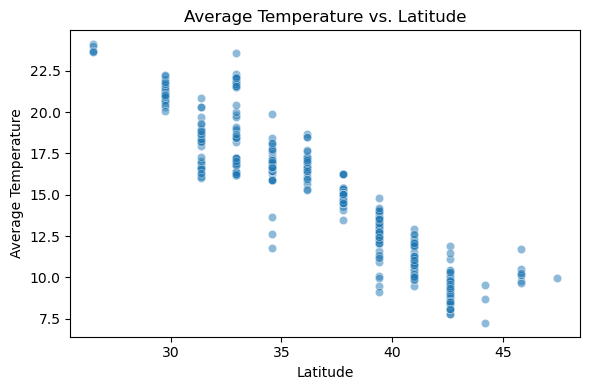

In [20]:
# Plot Temperature vs. Latitude
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["Latitude"], y=df["AverageTemperature"], alpha=0.5)
plt.xlabel("Latitude")
plt.ylabel("Average Temperature")
plt.title("Average Temperature vs. Latitude")
# Save the plot
plt.tight_layout()
plt.savefig("figures/temperature_vs_latitude.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Compute mutual information between Temperature and Pollution variables
X = df[["NO2 Mean", "SO2 Mean", "CO Mean"]]
y = df["AverageTemperature"]

my_scores = mutual_info_regression(X, y)
my_df = pd.DataFrame(my_scores, index=X.columns, columns=["Mutual Information"])
print(my_df)

          Mutual Information
NO2 Mean            0.214950
SO2 Mean            0.245289
CO Mean             0.200712


In [8]:
dcorr_no2 = distance_correlation(df["AverageTemperature"].dropna(), df["NO2 Mean"].dropna())
dcorr_so2 = distance_correlation(df["AverageTemperature"].dropna(), df["SO2 Mean"].dropna())
dcorr_co = distance_correlation(df["AverageTemperature"].dropna(), df["CO Mean"].dropna())

print(f"Distance Correlation - Temperature & NO2: {dcorr_no2:.4f}")
print(f"Distance Correlation - Temperature & SO2: {dcorr_so2:.4f}")
print(f"Distance Correlation - Temperature & CO: {dcorr_co:.4f}")

Distance Correlation - Temperature & NO2: 0.1182
Distance Correlation - Temperature & SO2: 0.3417
Distance Correlation - Temperature & CO: 0.1739


In [ ]:
# Linear Correlation between Temperature and Pollution 
pollution_vars = ["NO2 Mean", "SO2 Mean", "CO Mean"]
correlation_temp_pollution = df[["AverageTemperature"] + pollution_vars].corr(method='spearman')
print("\nCorrelation between Temperature and Pollution:")
print(correlation_temp_pollution["AverageTemperature"].drop("AverageTemperature"))


Correlation between Temperature and Pollution:
NO2 Mean   -0.043590
SO2 Mean   -0.290074
CO Mean     0.007859
Name: AverageTemperature, dtype: float64


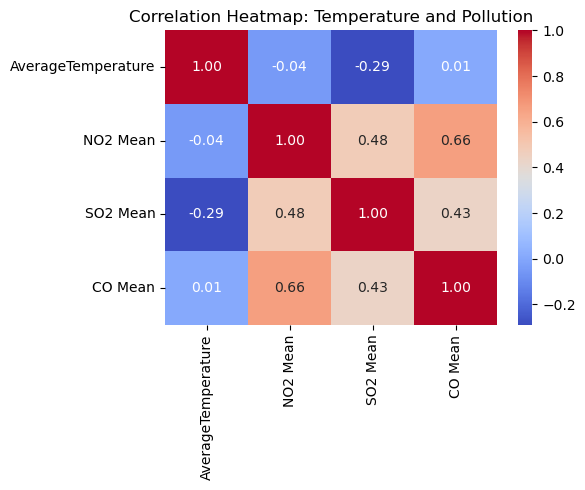

In [55]:
# Heatmap of temperature and pollution correlations
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_temp_pollution, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Temperature and Pollution")
# Save the plot
plt.tight_layout()
plt.savefig("figures/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

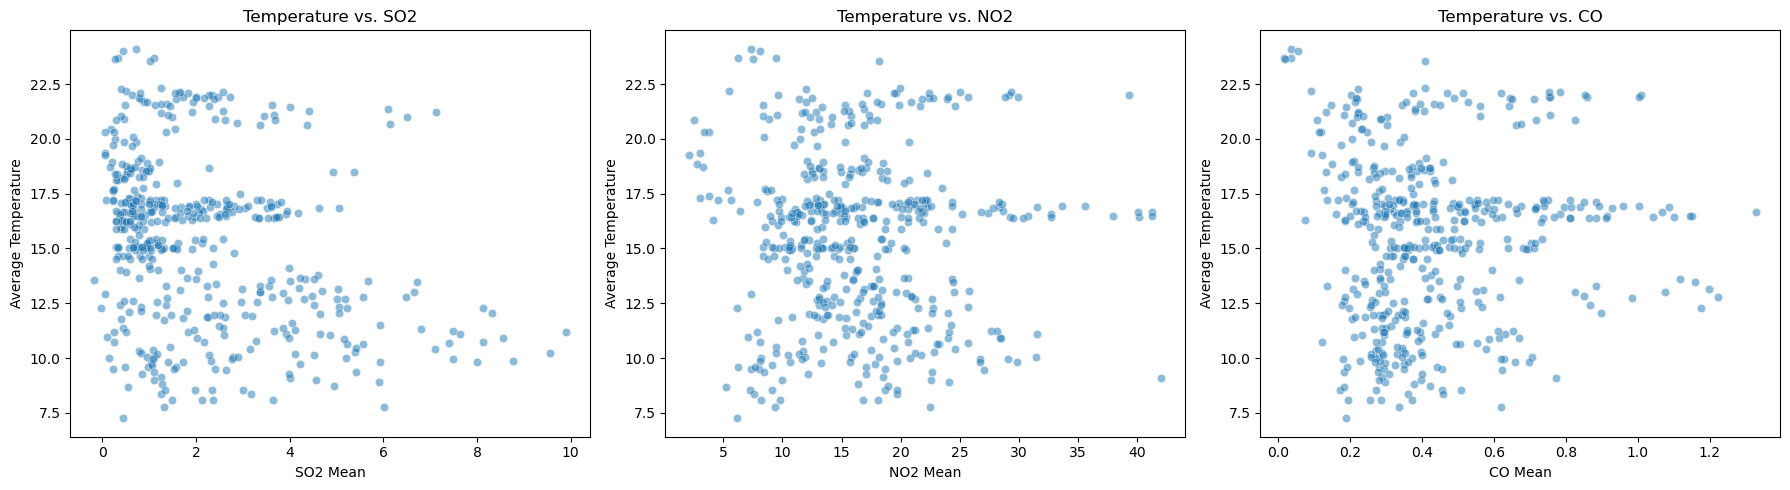

In [27]:
# Plot of "SO2 Mean", "NO2 Mean" and  "CO Mean" vs 	"AverageTemperature"
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

# Temperature vs. SO2
sns.scatterplot(ax=axes[0], x=df["SO2 Mean"], y=df["AverageTemperature"], alpha=0.5)
axes[0].set_xlabel("SO2 Mean")
axes[0].set_ylabel("Average Temperature")
axes[0].set_title("Temperature vs. SO2")

# Temperature vs. NO2
sns.scatterplot(ax=axes[1], x=df["NO2 Mean"], y=df["AverageTemperature"], alpha=0.5)
axes[1].set_xlabel("NO2 Mean")
axes[1].set_ylabel("Average Temperature")
axes[1].set_title("Temperature vs. NO2")

# Temperature vs. CO
sns.scatterplot(ax=axes[2], x=df["CO Mean"], y=df["AverageTemperature"], alpha=0.5)
axes[2].set_xlabel("CO Mean")
axes[2].set_ylabel("Average Temperature")
axes[2].set_title("Temperature vs. CO")


# Save the plot
plt.tight_layout()
plt.savefig("figures/pollution_vs_temperature.png", dpi=300, bbox_inches='tight')
plt.tight_layout()


Correlation between Temperature and Pollution:
           Pearson  Spearman   Kendall  Distance Correlation  \
NO2 Mean -0.040127 -0.043590 -0.032454              0.118242   
SO2 Mean -0.311894 -0.290074 -0.197766              0.341715   
CO Mean   0.025227  0.007859  0.009870              0.173909   

          Mutual Information  
NO2 Mean            0.214363  
SO2 Mean            0.246201  
CO Mean             0.202023  


<Figure size 800x600 with 0 Axes>

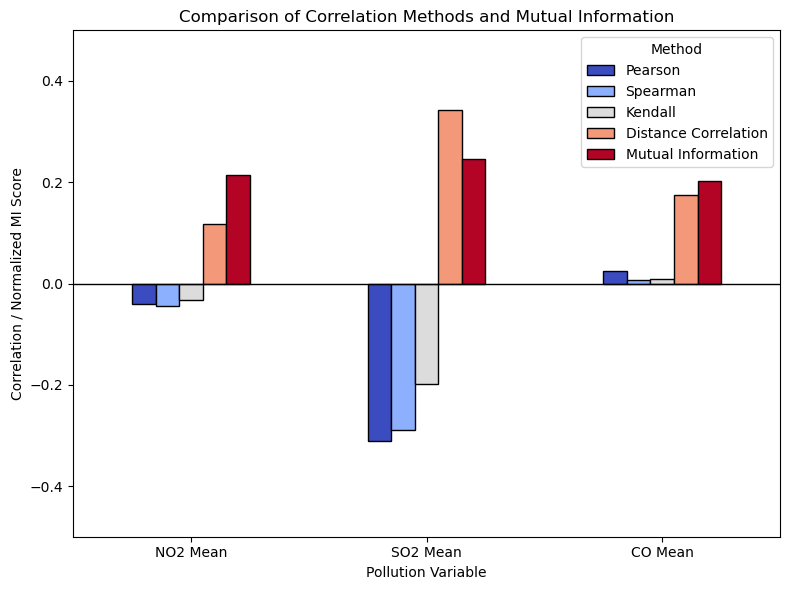

In [61]:
# Pollution variables
pollution_vars = ["NO2 Mean", "SO2 Mean", "CO Mean"]

# Compute Mutual Information
X = df[pollution_vars]
y = df["AverageTemperature"]

mi_scores = mutual_info_regression(X, y)
mi_df = pd.DataFrame(mi_scores, index=pollution_vars, columns=["Mutual Information"])

# Compute Correlations using different methods
correlation_results = {}
for var in pollution_vars:
    correlation_results[var] = {
        "Pearson": correlation(df, "AverageTemperature", var, method="pearson"),
        "Spearman": correlation(df, "AverageTemperature", var, method="spearman"),
        "Kendall": correlation(df, "AverageTemperature", var, method="kendall"),
        "Distance Correlation": distance_correlation(df["AverageTemperature"].dropna(), df[var].dropna())
    }

# Convert correlation results to DataFrame
correlation_df = pd.DataFrame(correlation_results).T

# Combine Mutual Information with Correlation results
combined_df = correlation_df.copy()
combined_df["Mutual Information"] = mi_df["Mutual Information"]

# Normalize Mutual Information to match correlation scale (-1, 1)
#mi_max = combined_df["Mutual Information"].max()
#combined_df["Mutual Information"] /= mi_max  # Normaliza a escala relativa

# Print correlation results
print("\nCorrelation between Temperature and Pollution:")
print(combined_df)

# Plot bar chart for comparison
plt.figure(figsize=(8, 6))
combined_df.plot(kind='bar', figsize=(8, 6), colormap="coolwarm", edgecolor="black")
plt.xlabel("Pollution Variable")
plt.ylabel("Correlation / Normalized MI Score")
plt.title("Comparison of Correlation Methods and Mutual Information")
plt.axhline(0, color='black', linewidth=1)
plt.ylim(-0.5, 0.5)
plt.legend(title="Method", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

# Save the plot
plt.tight_layout()
plt.savefig("figures/correlation_pollution_methods.png", dpi=300, bbox_inches='tight')
plt.show()



Correlation between Temperature Change and Pollution:
NO2 Mean   -0.144141
SO2 Mean   -0.099162
CO Mean    -0.122866
Name: Temp_Change, dtype: float64


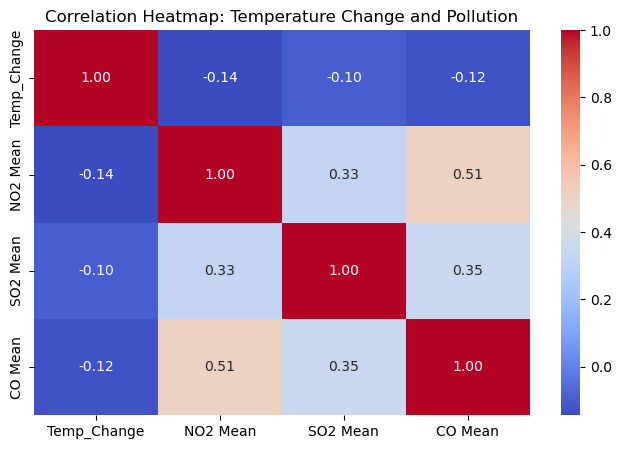

In [10]:
### 3 Correlation between Temperature Change and Pollution
# Compute the moving average of temperature over 3-year periods
df["Temp_MA3"] = df.groupby("City")["AverageTemperature"].transform(lambda x: x.rolling(window=3).mean())

# Compute temperature change as the difference between the last 3-year avg and the previous period
df["Temp_Change"] = df.groupby("City")["Temp_MA3"].diff(periods=3)

# Drop rows where Temp_Change is NaN (first years without enough data)
df_cleaned = df.dropna(subset=["Temp_Change"])

# Compute correlation with pollution
correlation_temp_change_pollution = df_cleaned[["Temp_Change"] + pollution_vars].corr()
print("\nCorrelation between Temperature Change and Pollution:")
print(correlation_temp_change_pollution["Temp_Change"].drop("Temp_Change"))

# Heatmap of temperature change vs pollution
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_temp_change_pollution, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Temperature Change and Pollution")
plt.show()

In [ ]:
# # Pollution variables
# pollution_vars = ["NO2 Mean", "SO2 Mean", "CO Mean"]

# # Compute correlation between Temperature and Pollution
# correlation_df = compute_all_correlations(df, "AverageTemperature", pollution_vars)
# print("\nCorrelation between Temperature and Pollution:")
# print(correlation_df)

# # Plot correlation results
# plot_correlation_results(correlation_df, "Comparison of Correlation Methods: Temperature vs Pollution")

# # Plot scatter plots for temperature vs pollution
# plot_scatterplots(df, pollution_vars, "AverageTemperature")

In [64]:
# Function to compute temperature change over 3-year periods per city
def compute_temperature_change(data):
    data = data.copy()
    data["Temp_MA3"] = data.groupby("City")["AverageTemperature"].transform(lambda x: x.rolling(window=3).mean())
    data["Temp_Change"] = data.groupby("City")["Temp_MA3"].diff(periods=3)
    return data.dropna(subset=["Temp_Change"])

# Compute temperature change per city
df_cleaned = compute_temperature_change(df)

# Compute correlation between Temperature Change and Pollution
correlation_temp_change_df = compute_all_correlations(df_cleaned, "Temp_Change", pollution_vars)
print("\nCorrelation between Temperature Change and Pollution:")
print(correlation_temp_change_df)

# Plot correlation results for temperature change
#plot_correlation_results(correlation_temp_change_df, "Correlation Methods: Temperature Change vs Pollution")


Correlation between Temperature Change and Pollution:
           Pearson  Spearman   Kendall  Distance Correlation
NO2 Mean -0.144141 -0.043483 -0.027459              0.168312
SO2 Mean -0.099162 -0.000733  0.006894              0.157390
CO Mean  -0.122866 -0.123544 -0.081433              0.220859


<Figure size 800x600 with 0 Axes>

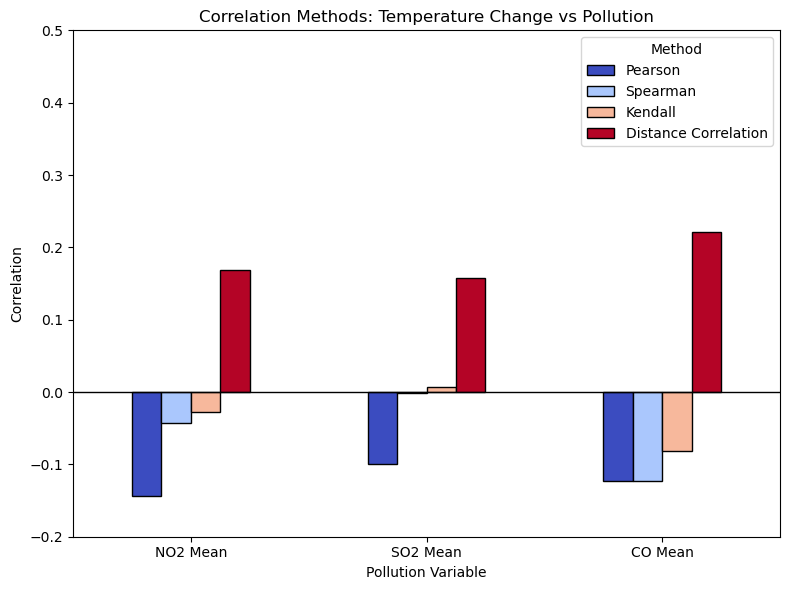

In [65]:

# Plot bar chart for comparison
plt.figure(figsize=(8, 6))
correlation_temp_change_df.plot(kind='bar', figsize=(8, 6), colormap="coolwarm", edgecolor="black")
plt.xlabel("Pollution Variable")
plt.ylabel("Correlation")
plt.title("Correlation Methods: Temperature Change vs Pollution")
plt.axhline(0, color='black', linewidth=1)
plt.ylim(-0.2, 0.5)
plt.legend(title="Method", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

# Save the plot
plt.tight_layout()
plt.savefig("figures/correlation_pollution_methods_per_3year.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary

##SECTION 3: ARIMA model for temperature forecasting